In [2]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 
import tensorflow as tf

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/test",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


In [4]:
classnames = train_ds.class_names
len(classnames),train_ds.class_names

(4, ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

In [5]:
NUM_IMAGES = []

for label in classnames:
    dir_name = "Alzheimer_s Dataset/train/" + label[:-2] +'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))
    
NUM_IMAGES,classnames

([717, 52, 2560, 1792],
 ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
IMG_SIZE = 180
IMAGE_SIZE = [180, 180]
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
WORK_DIR="Alzheimer_s Dataset/train"
work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


In [7]:
train_data, train_labels = train_data_gen.next()


In [8]:
print(train_data.shape, train_labels.shape)

(5121, 180, 180, 3) (5121, 4)


In [9]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(10240, 180, 180, 3) (10240, 4)


In [10]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
#build model
#-------VGG19--------

vgg = VGG19(input_shape=(180,180,3),weights='imagenet',include_top=False)
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)
modelvgg = Model(inputs=vgg.input,outputs=prediction)

In [12]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
modelvgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')  
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [13]:
hist = modelvgg.fit(
           train_data, train_labels,
           epochs=30,validation_data=(val_data, val_labels), 
            callbacks=[checkpoint, lr_reduce])

Epoch 1/30


2023-03-10 15:54:09.919815: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


205/205 [==============================] - 645s 3s/step - loss: 0.9050 - accuracy: 0.6248 - val_loss: 0.6314 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 2/30
205/205 [==============================] - 643s 3s/step - loss: 0.5909 - accuracy: 0.7560 - val_loss: 0.5467 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 3/30
205/205 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.7992
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
205/205 [==============================] - 646s 3s/step - loss: 0.4967 - accuracy: 0.7992 - val_loss: 0.4800 - val_accuracy: 0.8084 - lr: 0.0010
Epoch 4/30
205/205 [==============================] - 693s 3s/step - loss: 0.4159 - accuracy: 0.8533 - val_loss: 0.4633 - val_accuracy: 0.8225 - lr: 3.0000e-04
Epoch 5/30
205/205 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8549
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
205/205 [==============================] - 696s 3s

In [14]:
import os.path
if os.path.isfile('models/trained_model.hdf5') is False:
    modelvgg.save('models/trained_model.hdf5')

In [18]:
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

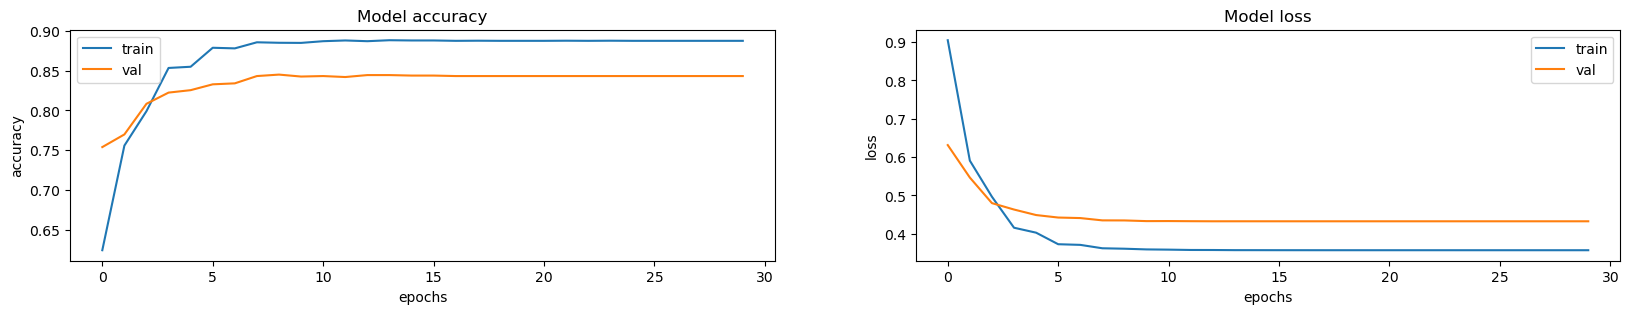

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
test_scores = modelvgg.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [16]:
pred_labels = modelvgg.predict(test_data)

64/64 [==============================] - 169s 3s/step


In [2]:
#Plot the confusion matrix to understand the classification in detail
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Reds', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)


NameError: name 'pred_labels' is not defined

In [1]:
from tensorflow.keras.models import load_model
new_model = load_model('models/trained_model.hdf5')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
predictions=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
def predict_new(path):
    img = cv2.imread(path)
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(180,180))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    predict=new_model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    print(f"Predicted: {predictions[pred[0]]}")

2023-03-11 17:14:08.650348: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 309ms/step
Predicted: MildDemented


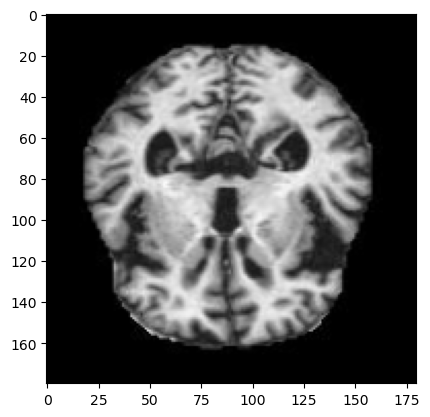

In [3]:
predict_new("/Users/nischithtn/gfg_backend/Alzheimer_s Dataset/train/MildDemented/mildDem1.jpg")